# Identificacion de lenguaje por medio de texto
La identificacion de lenguaje es una de las caracteristicas mas comunes de todas las aplicaciones web y/o redes sociales, usualmente estan amarradas estrictamente a la traduccion para mejorar la experiencia y accesibilidad del contenido. El fin de esta tarea es lograr identificar el lenguaje natural de un texto. Lo cual tiene muchos casos de uso para post/tweets/articulos y mas.

# El Dataset
El dataset viene de  https://dumps.wikimedia.org para 7 lenguajes pero me en este caso me enfocare unicamente en Español, Ingles y Frances ya que son los unicos lenguajes que manejamos actualmente en mi ambito laboral
# Proceso
- PreProcesar el texto para realizar NLP
- Construir y Experimentar el entramiento de un MLP usando Keras y Tensorflow
- Evaluar el modelo
- Realizar Pruebas 

# Importemos los paquetes necesarios

In [194]:
import os
import random
import numpy as np
import tensorflow as tf
import time

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
import keras.optimizers
from sklearn.externals.joblib import dump, load

/opt/anaconda2/envs/tf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Funciones de Ayuda

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def definir_alfabeto():
    base_en = 'abcdefghijklmnopqrstuvwxyz'
    special_chars = ' !?¿¡'
    french = 'àâæçéèêêîïôœùûüÿ'
    spanish = 'áéíóúüñ'
    all_lang_chars = base_en + french + spanish 
    small_chars = list(set(list(all_lang_chars)))
    small_chars.sort() 
    big_chars = list(set(list(all_lang_chars.upper())))
    big_chars.sort()
    small_chars += special_chars
    letters_string = ''
    letters = small_chars + big_chars
    for letter in letters:
        letters_string += letter
    return small_chars,big_chars,letters_string


def mostrar_matriz_de_conf(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

def removertags(text):
    return re.sub(r'<[^<]+?>', '', text)

def removerparentesis(text):
    return re.sub("[\(\[].*?[\)\]]", "", text)

def removerlineas(text):
    return text.replace('\n', ' ') 
    
def removerespacios(text):
    return re.sub(r'\s+', ' ', text)

def limpiar_text(text):
    text = removertags(text)
    text = removerlineas(text)
    text = removerlineas(text)
    text = removerespacios(text)
    return text

#################
# Pre Procesamiento #
#################

def obtener_sample(file_content,start_index,sample_size):
    while not (file_content[start_index].isspace()):
        start_index += 1
    while file_content[start_index].isspace():
        start_index += 1
    end_index = start_index+sample_size 
    while not (file_content[end_index].isspace()):
        end_index -= 1
    return file_content[start_index:end_index]

def contar_chars(text, alphabet):
    alphabet_counts = []
    for letter in alphabet:
        count = text.count(letter)
        alphabet_counts.append(count)
    return alphabet_counts

def obtener_fila(content,start_index,sample_size, alphabet):
    sample_text = obtener_sample(content,start_index,sample_size)
    counted_chars_all = contar_chars(sample_text.lower(), alphabet[0])
    counted_chars_big = contar_chars(sample_text, alphabet[1])
    all_parts = counted_chars_all + counted_chars_big
    return all_parts

## Hiperparametros de entrenamiento
Ahora vamos a definir los hiperparametros, en este caso sera el numero de iteraciones y el batch size ya que usaremos Batch Gradient Descent para nuestro entrenamiento, de igual forma si se corre en una pc con gpu disponible podemos aumentar el batch size para aumentar la tasa de convergencia

In [165]:
# Si hay gpu disponible
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 512  # numero de records usados por epoch
    EPOCHS = 12  # numero de epochs
    
# si no hay gpu disponible
else:
    # CPU
    BATCH_SIZE = 64
    EPOCHS = 12

# Preparacion de el Dataset
En este caso debido a que es un dataset bastante grande no estara subido en el repositorio github pero el data set viene de la siguiente URL https://www.floydhub.com/floydhub/datasets/language-identification/1 para entrenar el modelo se debera descargar y colocarlo en una carpeta local

In [166]:

# diccionario de lenguajes que nuestro calsificador considerara
LENGUAJES_DICT = {'en':0,'fr':1,'es':2}

# Largo maximo de caracters para entrenamiento y  prediccion 
LAR_MAX = 140

# numero de muestras por lenguaje
NUM_MUESTRAS = 250000

# Seed para aleatoriedad
SEED = 42

alfabeto = definir_alfabeto()
print('Alfabeto:')
print(alfabeto[2])

TAM_VOCAB = len(alfabeto[2])
print('Alfabeto len(TAM_VOCAB):', TAM_VOCAB)

# Folders from where load / store the raw, source, cleaned, samples and train_test data
data_directory = "/users/luisgarcia/floydhub-datasets-language-identification-1/data"
source_directory = os.path.join(data_directory, 'source')
cleaned_directory = os.path.join(data_directory, 'cleaned')
samples_directory = os.path.join('/tmp', 'samples')
train_test_directory = os.path.join('/tmp', 'train_test')

Alfabeto:
abcdefghijklmnopqrstuvwxyzàáâæçèéêíîïñóôùúûüÿœ !?¿¡ABCDEFGHIJKLMNOPQRSTUVWXYZÀÁÂÆÇÈÉÊÍÎÏÑÓÔÙÚÛÜŒŸ
Alfabeto len(TAM_VOCAB): 97


In [167]:
path = os.path.join(cleaned_directory, "de_cleaned.txt")
with open(path, 'r') as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*LAR_MAX)
    sample_text = obtener_sample(content,random_index,LAR_MAX)
    print ("1. TEXTO MUESTRA: \n", sample_text)
    print ("\n2. ALFABETO DE REFERENCIA: \n", alfabeto[0]+alfabeto[1])
    
    sample_input_row = obtener_fila(content, random_index, LAR_MAX, alfabeto)
    print ("\n3. FILA DE MUESTRA: \n",sample_input_row)
    
    input_size = len(sample_input_row)
    if input_size != TAM_VOCAB:
        print("Algo raro paso!")
        
    print ("\n4. TAMANO DE ENTRADA (VOCAB SIZE): ", input_size)
    del content

1. TEXTO MUESTRA: 
 gibt es aber auch eine katholische, eine neuapostolische und eine baptistische Gemeinde sowie eine Gemeinde Gottes und eine Gemeinde der

2. ALFABETO DE REFERENCIA: 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'á', 'â', 'æ', 'ç', 'è', 'é', 'ê', 'í', 'î', 'ï', 'ñ', 'ó', 'ô', 'ù', 'ú', 'û', 'ü', 'ÿ', 'œ', ' ', '!', '?', '¿', '¡', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Í', 'Î', 'Ï', 'Ñ', 'Ó', 'Ô', 'Ù', 'Ú', 'Û', 'Ü', 'Œ', 'Ÿ']

3. FILA DE MUESTRA: 
 [5, 3, 4, 6, 28, 0, 5, 5, 14, 0, 1, 2, 3, 11, 5, 2, 0, 2, 8, 7, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

4. TAMA

In [168]:
def size_en_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# Ahora que ya tenemos nuestras funciones de preprocesamiento , las vamos a usar para procesar los archivos de lenguajes
# y convertir el texto en data numerica para nuestra red neuronal
# prepara el array de numpy
sample_data = np.empty((NUM_MUESTRAS*len(LENGUAJES_DICT),input_size+1),dtype = np.uint16)
leng_seq = 0 # offset para cada lenguahes
jump_reduce = 0.2 #variable para evitar pasarnos del final del archivo

for leng in LENGUAJES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory, leng+"_cleaned.txt")
    with open(path, 'r') as f:
        print ("Procesando archivo : " + path)
        file_content = f.read()
        content_length = len(file_content)
        remaining = content_length - LAR_MAX*NUM_MUESTRAS
        jump = int(((remaining/NUM_MUESTRAS)*3)/4)
        print ("Tamano Archivo : ",size_en_mb(content_length),\
               " | # Posibles muestras : ",int(content_length/TAM_VOCAB),\
              "| # Caracteres Skipped : " + str(jump))
        for idx in range(NUM_MUESTRAS):
            input_row = obtener_fila(file_content, start_index, LAR_MAX, alfabeto)
            sample_data[NUM_MUESTRAS*leng_seq+idx,] = input_row + [LENGUAJES_DICT[leng]]
            start_index += LAR_MAX + jump
        del file_content
    leng_seq += 1
    print (100*"-")
     
# vamos a hacer shuffle a la data
np.random.shuffle(sample_data)
# reference input size
print ("Tamano Vocab : ",TAM_VOCAB )
print (100*"-")
print ("Numero de Muestras : ",sample_data.shape )

# crear el directiorio si no existe
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# guardar la informacion comprimida en disco
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(TAM_VOCAB)+".npz")
np.savez_compressed(path_smpl,data=sample_data)
print(path_smpl, "Tamano : ", size_en_mb(os.path.getsize(path_smpl)))
del sample_data

Procesando archivo : /users/luisgarcia/floydhub-datasets-language-identification-1/data/cleaned/en_cleaned.txt
Tamano Archivo :  101.42 MB  | # Posibles muestras :  1045576 | # Caracteres Skipped : 199
----------------------------------------------------------------------------------------------------
Procesando archivo : /users/luisgarcia/floydhub-datasets-language-identification-1/data/cleaned/fr_cleaned.txt
Tamano Archivo :  98.72 MB  | # Posibles muestras :  1017760 | # Caracteres Skipped : 191
----------------------------------------------------------------------------------------------------
Procesando archivo : /users/luisgarcia/floydhub-datasets-language-identification-1/data/cleaned/es_cleaned.txt
Tamano Archivo :  97.56 MB  | # Posibles muestras :  1005801 | # Caracteres Skipped : 187
----------------------------------------------------------------------------------------------------
Tamano Vocab :  97
--------------------------------------------------------------------------

## Verificando que este bien todo

In [169]:
# obtener codigo lenguaje
def get_lengid(lengid):    
    for dname, did in LENGUAJES_DICT.items():
        if did == lengid:
            return dname

# Cargando la informacion
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(TAM_VOCAB)+".npz")
dt = np.load(path_smpl)['data']

# Revisando una muestra aleatoria
random_index = random.randrange(0,dt.shape[0])
print ("Muestra Aleatoria : \n",dt[random_index,])
print ("\nLenguaje de Muestra : ",get_lengid(dt[random_index,][TAM_VOCAB]))

# Check if the data have equal share of different languages
print ("\nShape Datase (Muestras, Alfabeto):", dt.shape)
bins = np.bincount(dt[:,input_size])

print ("Conteo de muestras por lenguaje ") 
for lang_code in LENGUAJES_DICT: 
    print (lang_code, bins[LENGUAJES_DICT[lang_code]])

Muestra Aleatoria : 
 [12  1  7  2 11  3  4  6 12  0  0  5  2  6  3  1  0  8 11  8  4  0  2  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0
  0  0  0  2  0  1  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]

Lenguaje de Muestra :  en

Shape Datase (Muestras, Alfabeto): (750000, 98)
Conteo de muestras por lenguaje 
en 250000
fr 250000
es 250000


# Preprocesamiento de datos
Aunque la informacion ya esta lista para el entrenamiento tenemos que normalizarla esto para ayudar a nuestros modelos a alcanzar una taza de convergencia mas rapido ya que los datos son mas sencillos computacionalmente

In [170]:
# Aun nos falta un poco de preprocesamiento para poder entrenar nuestro MLP sobre todo en la escala
# Escalar nos ayudara que el algoritmo optimizador va a converger de forma correcta
# tambien tenemos que hacer one-hot encoding a nuestras clases para la salida de nuestro softmax
# vamos a convertir todo los datos a float
dt = dt.astype(np.float32)
# X y Y Split
X = dt[:, 0:input_size] # Muestras
Y = dt[:, input_size] # El ultimo elemento es el label
del dt

# Index random para obtener la muestra
random_index = random.randrange(0,X.shape[0])
print("Muestra antes de preprocesamiento:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])

# X Pre Procesamiento
# Normalizar y escalar
standard_scaler = preprocessing.StandardScaler().fit(X)
X = standard_scaler.transform(X)   
print ("X pre procesado :", X.shape)

# Y Pre Procesamiento
# One-hot encoding
Y = keras.utils.to_categorical(Y, num_classes=len(LENGUAJES_DICT))

# See the sample data
print("\nMuestra despues de preprocesamiento:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])

# Train/test split. Vamos a usar static ya que necesitamos resultados comparables para diferentes corridas con
# el fin de pruebas y toma de desiciones
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED)
del X, Y

# Crear los directorios
if not os.path.exists(train_test_directory):
    os.makedirs(train_test_directory)

# Guardar a disco
path_tt = os.path.join(train_test_directory,"train_test_data_"+str(TAM_VOCAB)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test)
print(path_tt, "Tamano : ",size_en_mb(os.path.getsize(path_tt)))
del X_train,Y_train,X_test,Y_test

Muestra antes de preprocesamiento:
X : 
 [ 7.  1.  6.  5. 19.  1.  0.  2.  6.  0.  0.  4.  2. 10.  6.  4.  2.  7.
  9.  8.  6.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  3.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 23.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
Y : 
 1.0
X pre procesado : (750000, 97)

Muestra despues de preprocesamiento:
X : 
 [-8.93468618e-01 -3.32060695e-01  9.17920530e-01  2.44210977e-02
  1.36987865e+00 -3.77986491e-01 -1.16430354e+00 -1.41217262e-01
 -5.96088231e-01 -5.38960636e-01 -4.69209522e-01 -7.20314026e-01
 -5.31015158e-01  7.82021105e-01 -5.18950820e-01  7.38213062e-01
  1.76657856e+00 -9.19680148e-02  4.28143293e-01  2.28501022e-01
  6.84853017e-01 -1.61697552e-01 -5.66822171e-01 -4.90597010e-01
 -8.87127697e-01 -4.17503774e-01 -3.53756905e-01 -3.18747878e-01
 -1.24981105e-01 -1.8547

# TRAIN - TEST SPLIT
Vamos a separa un 80% para entrenamiento y un 20% para pruebas

In [171]:
path_tt = os.path.join(train_test_directory, "train_test_data_"+str(TAM_VOCAB)+".npz")
train_test_data = np.load(path_tt)

# Train Set
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)

# Test Set
X_test = train_test_data['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data['Y_test']
print ("Y_test: ",Y_test.shape)

del train_test_data

X_train:  (600000, 97)
Y_train:  (600000, 3)
X_test:  (150000, 97)
Y_test:  (150000, 3)


# Arquitectura de nuestro MLP
Ahora empezaremos a experimentar con nuestra arquitectura con multiples capaz


In [55]:
model = Sequential()

model.add(Dense(100,input_dim=input_size, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dense(len(LENGUAJES_DICT), kernel_initializer="glorot_uniform", activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir="run")
checkpoint = ModelCheckpoint('/users/luisgarcia/cpmlp', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train,Y_train,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=[checkpoint,tensorboard],
                  shuffle=True,
                  verbose=2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               9800      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 303       
Total params: 10,103
Trainable params: 10,103
Non-trainable params: 0
_________________________________________________________________
Train on 540000 samples, validate on 60000 samples
Epoch 1/12
 - 10s - loss: 0.0363 - accuracy: 0.9882 - val_loss: 0.0303 - val_accuracy: 0.9898
Epoch 2/12
 - 10s - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.0290 - val_accuracy: 0.9902
Epoch 3/12
 - 10s - loss: 0.0274 - accuracy: 0.9909 - val_loss: 0.0277 - val_accuracy: 0.9906
Epoch 4/12
 - 10s - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0283 - val_accuracy: 0.9905
Epoch 5/12
 - 10s - loss: 0.0258 - accuracy: 0.9915 - val_loss: 0.0287 - val_accuracy

In [57]:
model = Sequential()

model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dense(len(LENGUAJES_DICT), kernel_initializer="glorot_uniform", activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir="run")
checkpoint = ModelCheckpoint('/users/luisgarcia/cpmlp', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train,Y_train,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=[checkpoint,tensorboard],
                  shuffle=True,
                  verbose=2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 500)               49000     
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 1503      
Total params: 50,503
Trainable params: 50,503
Non-trainable params: 0
_________________________________________________________________
Train on 540000 samples, validate on 60000 samples
Epoch 1/12
 - 13s - loss: 0.0562 - accuracy: 0.9830 - val_loss: 0.0644 - val_accuracy: 0.9843
Epoch 2/12
 - 12s - loss: 0.0456 - accuracy: 0.9857 - val_loss: 0.0754 - val_accuracy: 0.9851
Epoch 3/12
 - 12s - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.1040 - val_accuracy: 0.9847
Epoch 4/12
 - 12s - loss: 0.0425 - accuracy: 0.9869 - val_loss: 0.0596 - val_accuracy: 0.9857
Epoch 5/12
 - 12s - loss: 0.0403 - accuracy: 0.9875 - val_loss: 0.0672 - val_accuracy

In [58]:
model = Sequential()

model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dense(100, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dense(len(LENGUAJES_DICT), kernel_initializer="glorot_uniform", activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir="run")
checkpoint = ModelCheckpoint('/users/luisgarcia/cpmlp', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train,Y_train,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=[checkpoint,tensorboard],
                  shuffle=True,
                  verbose=2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 500)               49000     
_________________________________________________________________
dense_17 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_18 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 303       
Total params: 229,703
Trainable params: 229,703
Non-trainable params: 0
_________________________________________________________________
Train on 540000 samples, validate on 60000 samples
Epoch 1/12
 - 25s - loss: 0.0547 - accuracy: 0.9828 - val_loss: 0.0475 - val_accuracy: 0.9848
Epoch 2/12
 - 26s - loss: 0.0443 - accuracy: 0.9855 - val_loss: 0.0437 - val_accuracy: 0.9854
Epoch 3

In [56]:
model = Sequential()

model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_uniform", activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(LENGUAJES_DICT), kernel_initializer="glorot_uniform", activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir="run")
checkpoint = ModelCheckpoint('/users/luisgarcia/cpmlp', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train,Y_train,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=[checkpoint,tensorboard],
                  shuffle=True,
                  verbose=2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               49000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

In [172]:
model = Sequential()

model.add(Dense(100,input_dim=input_size, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(50, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(LENGUAJES_DICT), kernel_initializer="glorot_uniform", activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()
tensorboard = TensorBoard(log_dir="run")
checkpoint = ModelCheckpoint('/users/luisgarcia/cpmlp', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train,Y_train,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=[checkpoint,tensorboard],
                  shuffle=True,
                  verbose=2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               9800      
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                

/opt/anaconda2/envs/tf/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 15s - loss: 0.0606 - accuracy: 0.9821 - val_loss: 0.0475 - val_accuracy: 0.9847
Epoch 3/12
 - 14s - loss: 0.0573 - accuracy: 0.9828 - val_loss: 0.0459 - val_accuracy: 0.9853
Epoch 4/12
 - 14s - loss: 0.0552 - accuracy: 0.9832 - val_loss: 0.0459 - val_accuracy: 0.9855
Epoch 5/12
 - 14s - loss: 0.0545 - accuracy: 0.9834 - val_loss: 0.0450 - val_accuracy: 0.9854
Epoch 6/12
 - 14s - loss: 0.0529 - accuracy: 0.9839 - val_loss: 0.0447 - val_accuracy: 0.9859
Epoch 7/12
 - 14s - loss: 0.0523 - accuracy: 0.9840 - val_loss: 0.0434 - val_accuracy: 0.9861
Epoch 8/12
 - 15s - loss: 0.0517 - accuracy: 0.9842 - val_loss: 0.0438 - val_accuracy: 0.9862
Epoch 9/12
 - 15s - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.0435 - val_accuracy: 0.9864
Epoch 10/12
 - 15s - loss: 0.0511 - accuracy: 0.9844 - val_loss: 0.0437 - val_accuracy: 0.9864
Epoch 11/12
 - 15s - loss: 0.0508 - accuracy: 0.9846 - val_loss: 0.0429 - val_accuracy: 0.9864
Epoch 12/12
 - 15s - loss: 0.0502 - accuracy: 0.9847 - val_loss: 0.04

# MODELO ELEGIDO

- Capas Ocultas 3
- Dropout en cada Capa Oculta para evitar overfitting
- Optimizador Adam
- Activacion Sigmoid en las capaz intermedias
- Activacion softmax en la capa de salida
- Funcion de error : categorical_crossentropy

In [173]:
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(LENGUAJES_DICT))
LABELS =  list(LENGUAJES_DICT.keys())

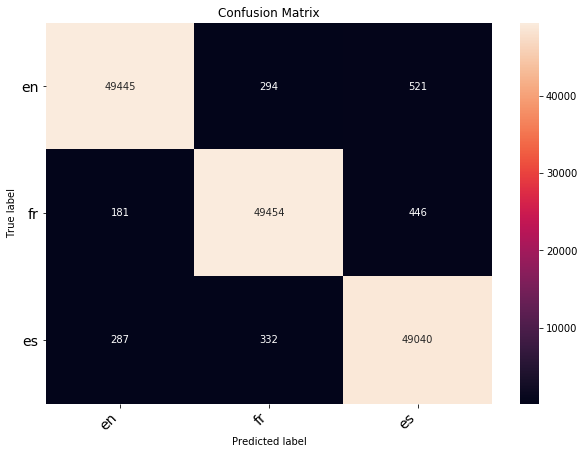

In [174]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(Y_pred,axis=1), np.argmax(Y_test,axis=1))
_ = mostrar_matriz_de_conf(cnf_matrix, LABELS)

In [175]:
print(classification_report(Y_test, Y_pred, target_names=LABELS))

              precision    recall  f1-score   support

          en       0.98      0.99      0.99     49913
          fr       0.99      0.99      0.99     50080
          es       0.99      0.98      0.98     50007

   micro avg       0.99      0.99      0.99    150000
   macro avg       0.99      0.99      0.99    150000
weighted avg       0.99      0.99      0.99    150000
 samples avg       0.99      0.99      0.99    150000



# Pruebas

In [183]:
def predecir(TEXT):
    cleaned_text = limpiar_text(TEXT)
    print(cleaned_text)
    print(len(cleaned_text))
    input_row = obtener_fila(cleaned_text, 0, LAR_MAX, alfabeto)
    print(input_row)
    test_array = standard_scaler.transform([input_row])
    
    raw_score = model.predict(test_array)
    
    print(raw_score)
    pred_idx= np.argmax(raw_score, axis=1)[0]
    score = raw_score[0][pred_idx]*100
    print('PREDICIENDO')
    prediction = LABELS[model.predict_classes(test_array)[0]]
    print('TEXTO:', TEXT, '\nPREDICCION:', prediction.upper(), '\nSCORE:', score)


In [184]:
predecir("Dedicada esta sección a la reseña de los compositores nativos y obras que han producido, con ligeros comentarios propios a cada uno, parécenos oportuno dar ligeras noticias sobre el origen de la composición.")

Dedicada esta sección a la reseña de los compositores nativos y obras que han producido, con ligeros comentarios propios a cada uno, parécenos oportuno dar ligeras noticias sobre el origen de la composición.
207
[12, 1, 8, 4, 10, 0, 1, 1, 7, 0, 0, 3, 2, 7, 16, 5, 1, 8, 12, 4, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[1.5282501e-06 1.0179316e-05 9.9998832e-01]]
PREDICIENDO
TEXTO: Dedicada esta sección a la reseña de los compositores nativos y obras que han producido, con ligeros comentarios propios a cada uno, parécenos oportuno dar ligeras noticias sobre el origen de la composición. 
PREDICCION: ES 
SCORE: 99.9988317489624


In [185]:
predecir("The HackerRank Virtual Career Fair has three days packed with speakers, panels, and recruiter AMAs. We are kicking off Monday with a keynote from Gayle McDowell, the author of Cracking the Coding Interview!")

The HackerRank Virtual Career Fair has three days packed with speakers, panels, and recruiter AMAs. We are kicking off Monday with a keynote from Gayle McDowell, the author of Cracking the Coding Interview!
206
[16, 0, 5, 4, 15, 3, 1, 5, 7, 0, 7, 2, 2, 6, 3, 3, 0, 12, 6, 6, 2, 1, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[9.996673e-01 5.902279e-05 2.737781e-04]]
PREDICIENDO
TEXTO: The HackerRank Virtual Career Fair has three days packed with speakers, panels, and recruiter AMAs. We are kicking off Monday with a keynote from Gayle McDowell, the author of Cracking the Coding Interview! 
PREDICCION: EN 
SCORE: 99.96672868728638


In [186]:
predecir("Voilà cinq mois que j'en faisais fonction, et, ma foi, je supportais bien cette responsabilité et goûtais fort cette indépendance. Je puis même affirmer, sans me flatter.")

Voilà cinq mois que j'en faisais fonction, et, ma foi, je supportais bien cette responsabilité et goûtais fort cette indépendance. Je puis même affirmer, sans me flatter.
170
[7, 2, 5, 2, 15, 4, 1, 0, 13, 3, 0, 1, 4, 9, 8, 5, 2, 3, 9, 11, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[5.0314009e-07 9.9997270e-01 2.6766382e-05]]
PREDICIENDO
TEXTO: Voilà cinq mois que j'en faisais fonction, et, ma foi, je supportais bien cette responsabilité et goûtais fort cette indépendance. Je puis même affirmer, sans me flatter. 
PREDICCION: FR 
SCORE: 99.99727010726929


In [188]:
predecir("Hola como estas mi nombre es luis renato garcia lopez y estoy estudiando en la universidad galileo una maestria en ciencia de datos , la carrera es muy interesante")

Hola como estas mi nombre es luis renato garcia lopez y estoy estudiando en la universidad galileo una maestria en ciencia de datos , la carrera es muy interesante
163
[16, 1, 5, 6, 15, 0, 2, 0, 10, 0, 0, 6, 4, 8, 9, 1, 0, 8, 9, 6, 4, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[3.4452189e-06 2.0917732e-05 9.9997568e-01]]
PREDICIENDO
TEXTO: Hola como estas mi nombre es luis renato garcia lopez y estoy estudiando en la universidad galileo una maestria en ciencia de datos , la carrera es muy interesante 
PREDICCION: ES 
SCORE: 99.99756813049316


In [192]:
predecir(" Buses are on the way, they have left the school.  Thank you for your flexibility today. Buses are on the way, they have left the school.  Thank you for your flexibility today. ")

 Buses are on the way, they have left the school. Thank you for your flexibility today. Buses are on the way, they have left the school. Thank you for your flexibility today. 
175
[8, 3, 2, 1, 15, 4, 0, 11, 3, 0, 1, 6, 0, 3, 10, 0, 0, 4, 6, 11, 4, 2, 2, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[9.9985468e-01 3.2273161e-05 1.1293934e-04]]
PREDICIENDO
TEXTO:  Buses are on the way, they have left the school.  Thank you for your flexibility today. Buses are on the way, they have left the school.  Thank you for your flexibility today.  
PREDICCION: EN 
SCORE: 99.98546838760376


# Vamos a Guardar el modelo ya que lo vamos a utilizar para la extraccion de datos de nuestra CNN

In [195]:
model.save('modeloMLP.h5')
dump(standard_scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']